<a href="https://colab.research.google.com/github/Gautam-Chauhan/MAPS-Internship-Code/blob/main/object_detection_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Inference with TensorFlow Model Garden

This notebook uses my fine-tuned object detection model to detect trash in images of the streets and drainage canals in the city of Quelimane in Mozambique.

Based on the following tutorial:

https://www.tensorflow.org/tfmodels/vision/object_detection

To use this notebook to identify trash in some unseen images, run the cells in the following sections, one by one, in order:

- Preliminaries
- Inference on Dataset

The section titled "Visualise Test Images and Predictions" is just for looking at some examples of images from a test dataset. You do NOT need to run this section to make new predictions.

This notebook will require the data and trained model to be located in a google drive.

To use this code, you need the following folder structure:

- A folder called Object_Detection inside your drive
- Folders for the model checkpoints, exported model and data should be placed inside that folder

### PRELIMINARIES

#### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Install packages

The following cell will install a new version of NumPy, restart the session when prompted after running this cell:

In [3]:
# Uninstall the current numpy version to avoid conflicts
!pip uninstall -y numpy
# Install a numpy version compatible with TensorFlow
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 119.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
# Install tf-models-official, ensuring compatibility with the installed numpy and TensorFlow versions
!pip install -U -q "tf-models-official"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.9 MB/s eta 0:00:00


#### Import relevant libraries

In [2]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from six import BytesIO
import time
import cv2
import csv
import glob

In [3]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.19.0


#### Set paths to files in drive

In [4]:
model_dir = '/content/drive/MyDrive/Object_Detection/FINAL_MODEL_CHECKPOINTS'
export_dir ='/content/drive/MyDrive/Object_Detection/FINAL_MODEL_EXPORT'

#### Load trained model from google drive

In [5]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

#### Useful functions

Some useful functions for loading data from files and resizing images:

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array, so that we can make predictions
  on it using the trained model. The output array has shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(image_data))
  return image



  #(im_width, im_height) = image.size
  #return np.array(image.getdata()).reshape(
      #(1, im_height, im_width, 3)).astype(np.uint8)


def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

### VISUALISE TEST IMAGES AND PREDICTIONS

#### Ground-truth bounding boxes for test images

Specify the location of the test dataset in the google drive:

In [7]:
test_data_input_path = '/content/drive/MyDrive/Object_Detection/Annotations/test.record'

For each image in the test dataset, use the test TensorFlow records file to get the ground-truth bounding boxes, and count the number for each image. Also write the images with the ground-truth bounding boxes to a folder in google drive.

In [8]:
category_index={
    1: {
        'id': 1,
        'name': 'Trash'
       },
}
tf_ex_decoder = TfExampleDecoder()

In [33]:
true_num_objects = {}
test_dataset = tf.data.TFRecordDataset(test_data_input_path)
use_normalized_coordinates=True
min_score_thresh = 0.25

for i, serialized_example in enumerate(test_dataset):

  example = tf.train.Example()
  example.ParseFromString(serialized_example.numpy())
  filename = example.features.feature['image/filename'].bytes_list.value[0].decode('utf-8')

  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = decoded_tensors['image'].numpy().astype('uint8')
  scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))

  true_num_objects[filename] = len(scores)

  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image,
      decoded_tensors['groundtruth_boxes'].numpy(),
      decoded_tensors['groundtruth_classes'].numpy().astype('int'),
      scores,
      category_index=category_index,
      use_normalized_coordinates=use_normalized_coordinates,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)

  image = image[:, :, ::-1]
  folder_path = '/content/drive/MyDrive/Object_Detection/test_images_true/'
  filename = str(decoded_tensors['source_id'].numpy())
  cv2.imwrite(folder_path + filename + ".jpg", image)

for key in list(true_num_objects.keys())[:5]:
  print((key,true_num_objects[key]))

('1742796461509.jpg', 1)
('1742797772698.jpg', 1)
('1742799793611.jpg', 17)
('1742800648623.jpg', 12)
('1742800975408.jpg', 0)


#### Predicted bounding boxes for test images

Specify location of test images in the google drive:

In [11]:
test_images_path = '/content/drive/MyDrive/Object_Detection/test/'

For each test image, use the model to make a prediction of the number of objects and add this to a dictionary with the name of the image file as the key. Also, save a copy of the image with the predicted bounding boxes to my google drive.

In [32]:
# Rescale images to the size that was used for training
HEIGHT = 1024
WIDTH = 1024
input_image_size = (HEIGHT, WIDTH)
min_score_thresh = 0.25
predicted_num_objects = {}

for filepath in glob.glob(test_images_path + '*.jpg'):

  image = load_image_into_numpy_array(filepath)
  image = build_inputs_for_object_detection(image, input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)

  detections = [score for score in result['detection_scores'][0].numpy() if score > 0.25]
  filename = str(filepath.removeprefix(test_images_path))
  predicted_num_objects[filename]=len(detections)

  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)

  image_np = image_np[:, :, ::-1]
  folder_path = '/content/drive/MyDrive/Object_Detection/test_images_predictions/'
  filename = str(filepath.removeprefix(test_images_path))
  cv2.imwrite(folder_path + filename, image_np)

for key in list(predicted_num_objects.keys())[:5]:
  print((key,predicted_num_objects[key]))

('1742978181612.jpg', 0)
('1742797772698.jpg', 3)
('1742999763639.jpg', 11)
('1743173379181.jpg', 1)
('1742800975408.jpg', 6)


#### Plot the 'correct' number of detections and predicted number of detections

Print the predicted number of bounding boxes and the true number of bounding boxes for each image. Show this in a scatter graph:

1742796461509.jpg: (1, 0)
1742797772698.jpg: (1, 3)
1742799793611.jpg: (17, 7)
1742800648623.jpg: (12, 9)
1742800975408.jpg: (0, 6)
1742802453328.jpg: (0, 1)
1742802997434.jpg: (3, 6)
1742803031794.jpg: (16, 11)
1742805661199.jpg: (4, 5)
1742807312703.jpg: (9, 13)
1742808065341.jpg: (0, 0)
1742820874630.jpg: (2, 2)
1742821572060.jpg: (4, 1)
1742824387337.jpg: (3, 10)
1742824913044.jpg: (10, 9)
1742884849548.jpg: (9, 7)
1742885612840.jpg: (9, 7)
1742886001840.jpg: (0, 2)
1742886300257.jpg: (11, 10)
1742888417154.jpg: (0, 0)
1742892551263.jpg: (12, 10)
1742894696364.jpg: (4, 4)
1742902946655.jpg: (1, 5)
1742908279112.jpg: (0, 6)
1742909197701.jpg: (0, 6)
1742913106633.jpg: (3, 2)
1742972052757.jpg: (33, 21)
1742972255845.jpg: (2, 2)
1742975342064.jpg: (3, 0)
1742976236628.jpg: (5, 4)
1742977589337.jpg: (0, 5)
1742978181612.jpg: (1, 0)
1742980732042.jpg: (1, 0)
1742982511677.jpg: (51, 41)
1742982624173.jpg: (0, 0)
1742982630239.jpg: (0, 0)
1742986233563.jpg: (0, 1)
1742990642926.jpg: (0, 

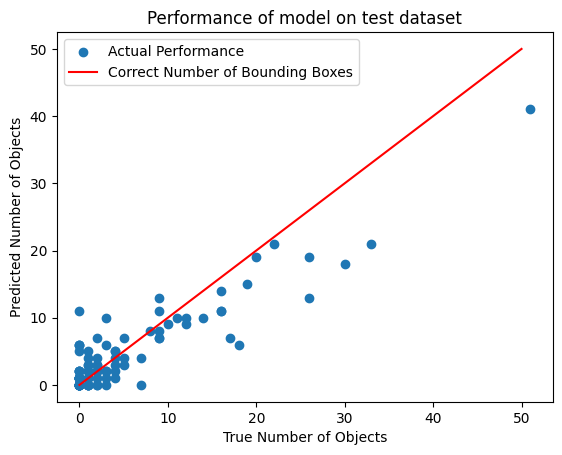

In [39]:
true_num_objects_list = []
predicted_num_objects_list = []
for filename in true_num_objects.keys():
  true_number = true_num_objects[filename]
  predicted_number = predicted_num_objects[filename]
  true_num_objects_list.append(true_number)
  predicted_num_objects_list.append(predicted_number)
  print(filename + ": " + str((true_number,predicted_number)))

plt.scatter(true_num_objects_list, predicted_num_objects_list, label="Actual Performance")
plt.xlabel("True Number of Objects")
plt.ylabel("Predicted Number of Objects")
plt.title("Performance of model on test dataset")

xs = np.linspace(0,50,1000)
plt.plot(xs,xs, color = "red", label="Correct Number of Bounding Boxes")
plt.legend()

This graph suggests that the predicted number of bounding boxes can be used as an indicator of whether there is a high amount of trash or a low amount of trash, as the predicted number of bounding boxes generally increases with the true number of bounding boxes.

Do the same for area:

### INFERENCE ON DATASET

Run the model on each of the unseen images and get the number of bounding boxes. Add them to a list, and then at the end, write the whole list to a csv file.

In [9]:
# Rescale input to size (1024,1024)
input_size = (1024,1024)
output_info = []
# CHANGE THIS PATH WITH THE NAME OF YOUR DATA FOLDER
data_path = '/content/drive/MyDrive/Object_Detection/test/'
# CHANGE THIS FILENAME TO THE DESIRED NAME OF YOUR CSV FILE
output_filename = 'test2.csv'

for filepath in glob.glob(data_path + '*.jpg'):

  image = load_image_into_numpy_array(filepath)
  image = build_inputs_for_object_detection(image,input_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)

  # Count the number of bounding boxes above the confidence threshold of 0.25
  count = len([score for score in result['detection_scores'][0] if score > 0.25])

  filename = filepath.removeprefix(data_path)
  image_dict = {'image_id':filename, 'num_detections':count}
  output_info.append(image_dict)

# Path to the location where you want to store the CSV files
output_dir = '/content/drive/MyDrive/Object_Detection/output_data/'
# CHANGE THIS LINE WITH THE DESIRED NAME OF YOUR CSV FILE
output_path = os.path.join(output_dir, output_filename)

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

with open(output_path, 'w', newline='') as csvfile:
  fieldnames = ['image_id','num_detections']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()
  writer.writerows(output_info)